### Tensorflow gives lots of warning that I could ignore and that makes our notebook tidy.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Importing all the necessary libraries.

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

2023-08-19 20:32:12.450359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-19 20:32:13.058791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### This is another way to load image files using tf.data.Dataset but later I found *image_dataset_from_directory* from tf.keras.utils do dropped this way as that was more handy.

## Loading Data using *tf.keras.utils.image_dataset_from_directory*

In [4]:
image_size = 256
batch_size = 32

In [5]:
dataset = tf.keras.utils.image_dataset_from_directory(directory="data/PlantVillage/",
                                            shuffle=True,
                                            image_size=(image_size,image_size),
                                            batch_size=batch_size)

Found 2152 files belonging to 3 classes.


In [6]:
len(dataset)

68

### This is because we have a batch of 32 images each thus 68 batch of 32 images each or less

In [7]:
for img_batch,img_label in dataset.take(1):
    print(img_batch.numpy()[0].shape)
    print(img_label.numpy()[0])

(256, 256, 3)
1


In [8]:
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

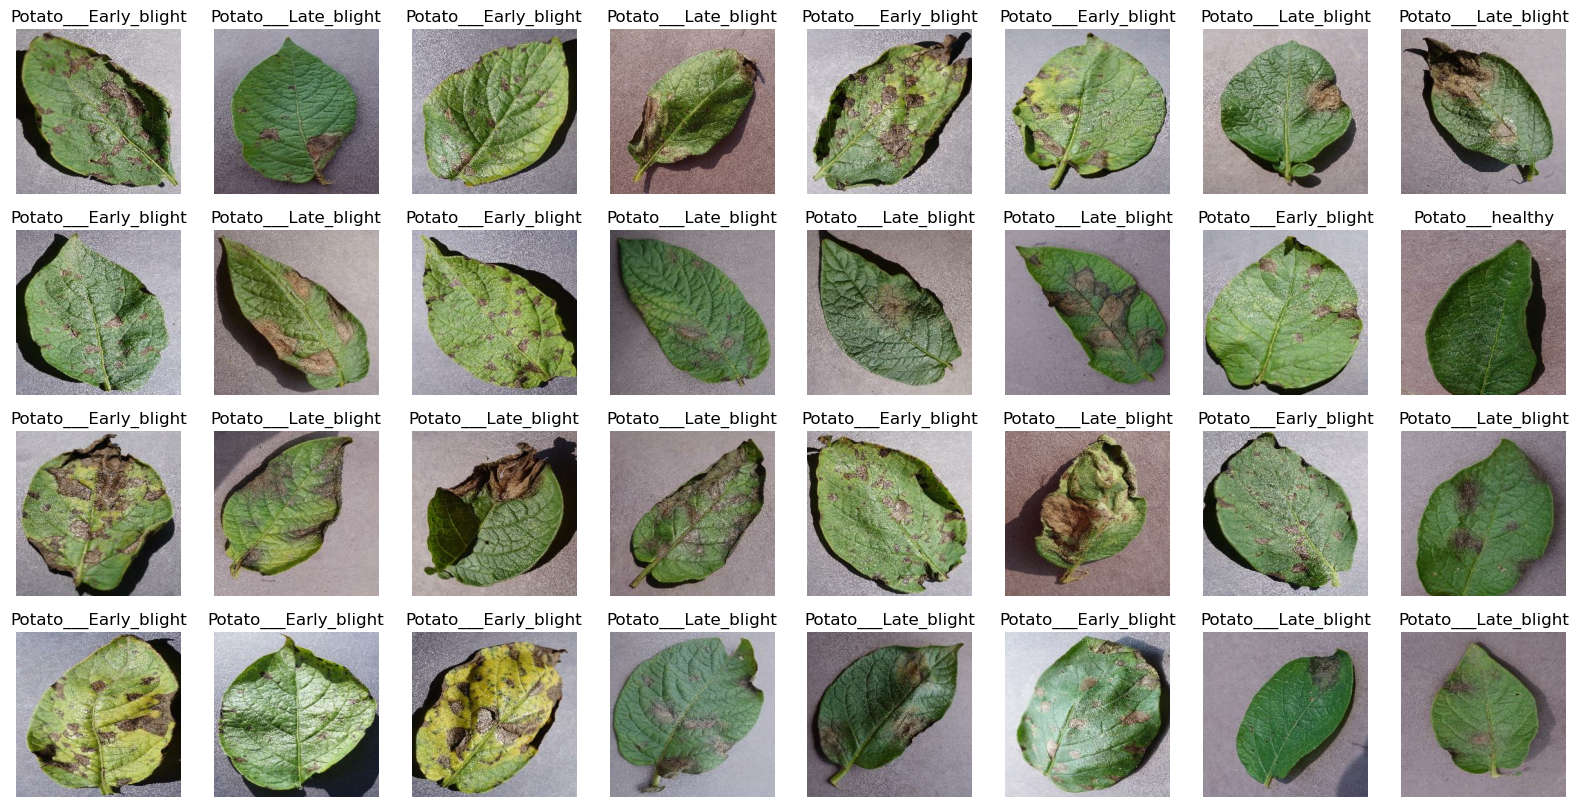

In [9]:
plt.figure(figsize=(20,10))#width,height
for img_batch,label_batch in dataset.take(1):
    for i in range(len(img_batch)):
        ax = plt.subplot(4,8,i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis("off")     

## Splliting the Dataset (train test validation split)

#### Here is how we will do it.
We have length of our dataset. and we have desired partiton values.
Then we will just take 80% of total batches as **train_ds**.
Then for **val_ds** we will **skip** equal to **train_size** and then **take equal** to **val_size**.
then for **test_ds** we will **skip** for batches equal to **train_size + val_size** and whatever left will be taken by test_ds

In [10]:
def get_split_dataset(dataset,train_size=0.8,val_size=0.1,test_size=0.1,shuffle=True,buffer=1000):
    '''SUM of train test and val sizes must be equal to 1
       Returns split data in following order : train_ds, val_ds, test_ds
    '''
    
    if train_size+val_size+test_size != 1.0:
        print("Invalid proportion of splitings. Sum is not 1.")
        return None
    if shuffle:
        dataset.shuffle(buffer,seed=12)
    
    total_batches = len(dataset)
    
    train_size = int(train_size*total_batches)
    train_ds = dataset.take(train_size)
    
    val_size = int(val_size*total_batches)
    val_ds = dataset.skip(train_size).take(val_size)
    
    test_ds = dataset.skip(train_size+val_size)
    
    return train_ds,val_ds,test_ds

In [11]:
train_ds,val_ds,test_ds = get_split_dataset(dataset)

In [12]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


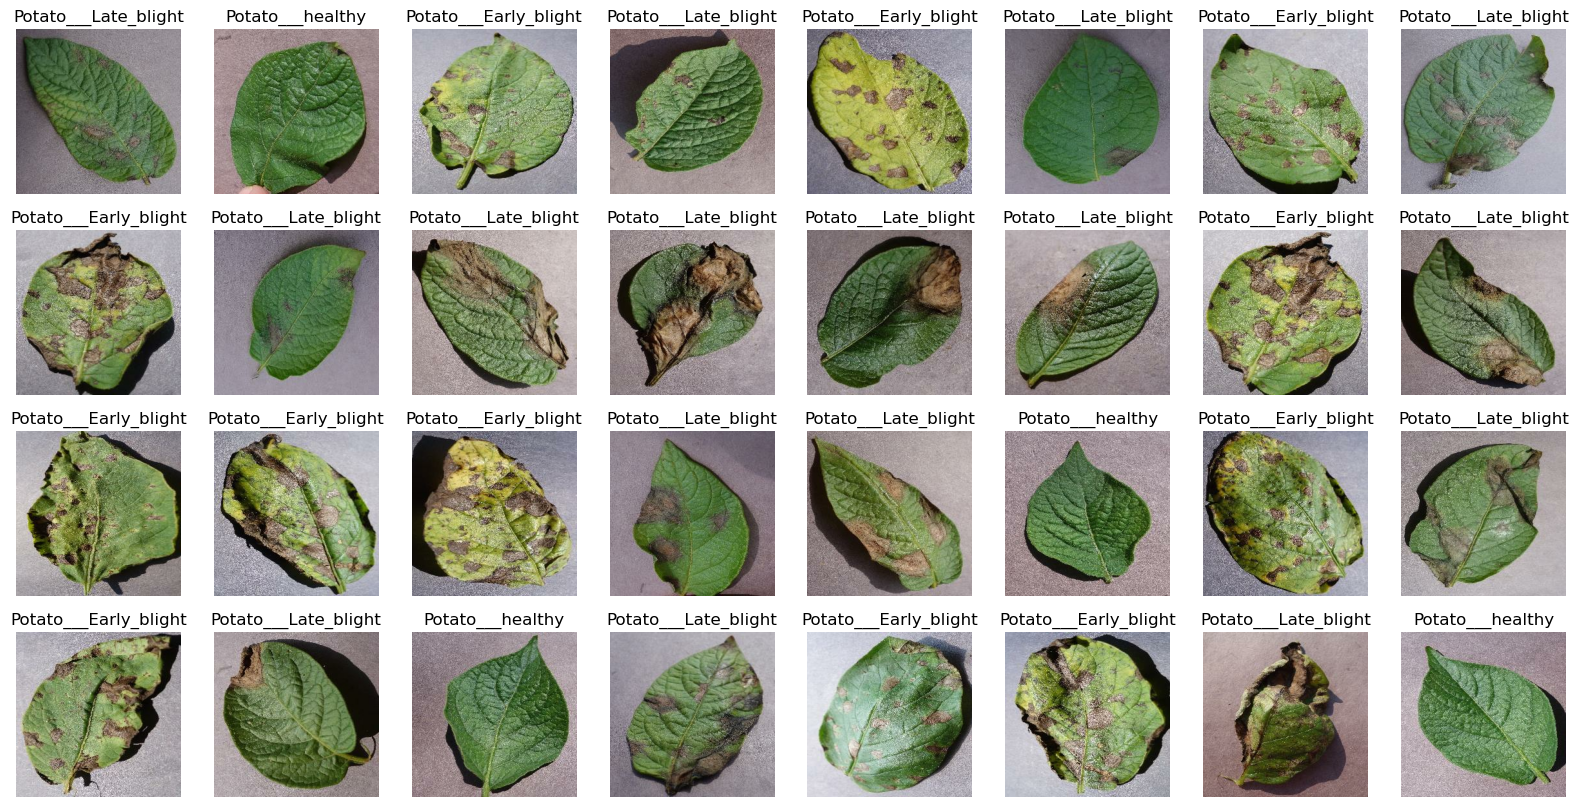

In [13]:
plt.figure(figsize=(20,10))#width,height
for img_batch,label_batch in train_ds.take(1):
    for i in range(len(img_batch)):
        ax = plt.subplot(4,8,i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis("off")     

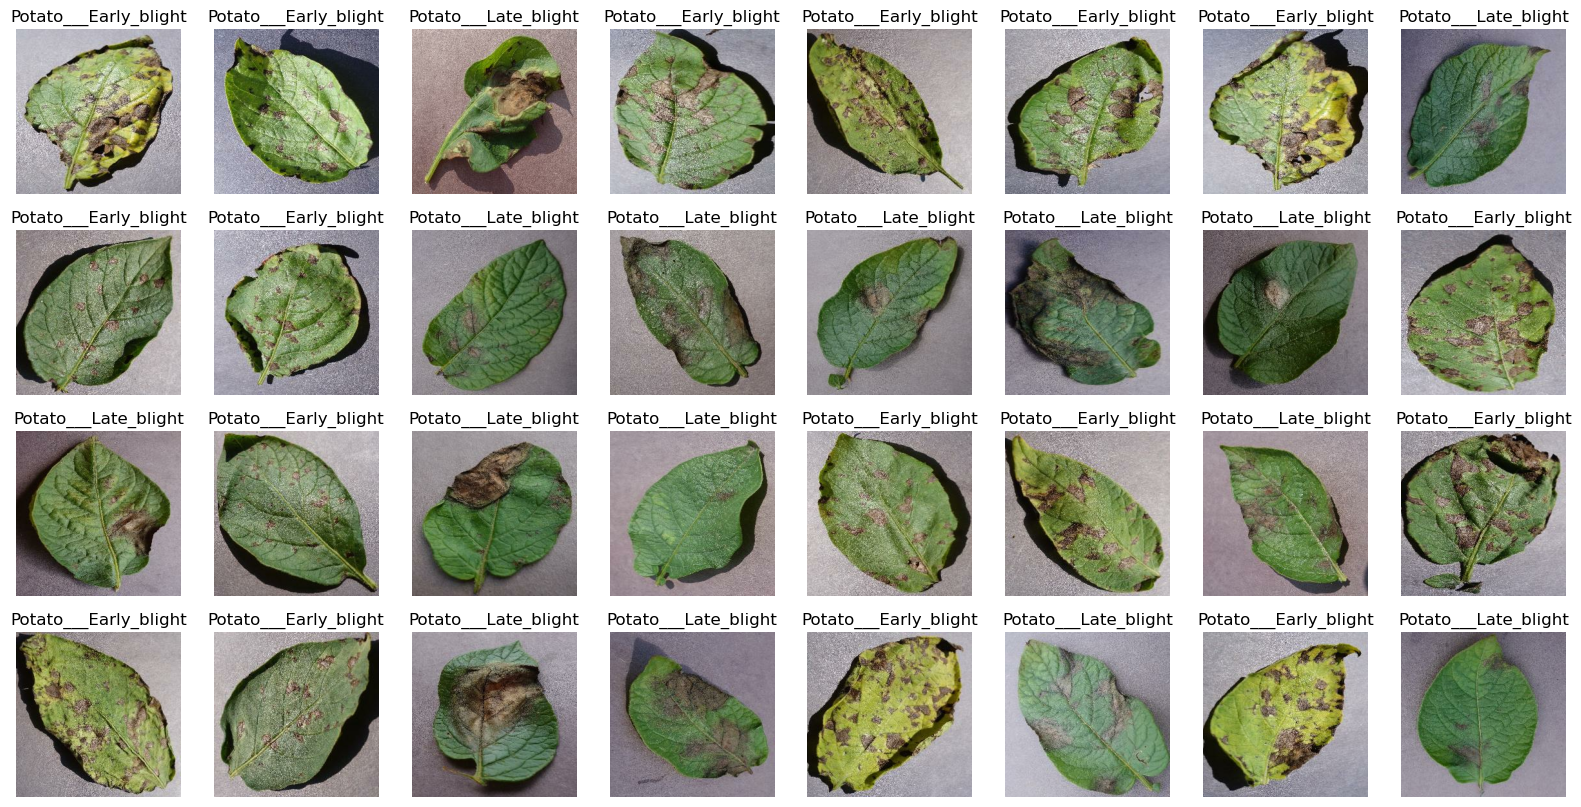

In [14]:
plt.figure(figsize=(20,10))#width,height
for img_batch,label_batch in val_ds.take(1):
    for i in range(len(img_batch)):
        ax = plt.subplot(4,8,i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis("off")     

# TensorFlow Dataset Processing Pipeline Explanation

## Introduction

In this explanation, we'll break down what happens on a batch level after applying the `.cache()`, `.shuffle(1000)`, and `.prefetch()` processes to your `train_ds` TensorFlow dataset. Let's assume that:

- `train_ds` has 54 batches.
- Each batch contains 32 images of potato plant leaves.

## Loading and Caching

- **First Epoch:**
  - The dataset is loaded, and its elements (batches) are cached. This involves loading all 54 batches of 32 images each into memory or disk.
  - The cached data is reshuffled using the `.shuffle(1000)` process, ensuring randomness.

## Training Process on Batch Level

1. **Epoch 1 - Batch 1:**
   - The first batch of 32 images is fetched from the cached and shuffled data.
   - Preprocessing and transformation are applied to this batch.
   - The model trains on this batch.
   - Meanwhile, the next batch (Batch 2) is being prefetched in the background.

2. **Epoch 1 - Batch 2:**
   - The second batch of 32 images is fetched from the cached and shuffled data.
   - Preprocessing and transformation are applied.
   - The model trains on this batch.
   - Meanwhile, Batch 3 is being prefetched.

3. **... (Continues for all 54 batches)**

## Epoch Transition and Prefetching

- **Epoch 2 - Batch 1:**
   - Since the data is cached, the first batch from the previous epoch is used (now reshuffled randomly again).
   - Preprocessing, transformation, and training occur as before.
   - Meanwhile, Batch 2 from Epoch 2 is being prefetched.

- **Epoch 2 - Batch 2:**
   - The second batch from the cached data of the previous epoch is used.
   - Preprocessing, transformation, and training occur.
   - Meanwhile, Batch 3 from Epoch 2 is being prefetched.

- **... (Continues for all 54 batches)**

## Conclusion

In summary, our dataset is preprocessed, cached, and reshuffled once at the beginning of training. For each epoch, the cached and reshuffled data is used for training. During each epoch, the prefetching mechanism ensures that the next batch is being prepared in the background while the current batch is being processed by the model. This optimization helps make the most efficient use of your resources (CPU, memory, and GPU) and reduces the waiting time between processing and training steps.


In [15]:
# Transformations for train_ds
train_ds = train_ds.cache()  # Cache the dataset elements
train_ds = train_ds.shuffle(buffer_size=1000)  # Shuffle with a buffer size of 1000
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch with automatic tuning

# Transformations for test_ds
test_ds = test_ds.cache()  # Cache the dataset elements
test_ds = test_ds.shuffle(buffer_size=1000)  # Shuffle with a buffer size of 1000
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch with automatic tuning

# Transformations for val_ds
val_ds = val_ds.cache()  # Cache the dataset elements
val_ds = val_ds.shuffle(buffer_size=1000)  # Shuffle with a buffer size of 1000
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch with automatic tuning


# We could have done all of this using chaining of operation but decided not to,
#since I had to explain steps in my notebook

# Data Augmentation

### To reduce overfitting of CNN model due to specifc distance or angle of leaf

#### Importing functions to randomly flip and alter contrast and zoom and resize and rescale etc.

In [16]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling,Resizing,RandomFlip,RandomZoom,RandomContrast,RandomRotation

In [17]:
resize_rescale_layer = [
    Resizing(image_size,image_size),
    Rescaling(scale=1./255)
]
augmentation_layer = [
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.1)
]

# Building Model (CNN Model using Sequential API from keras

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D

In [19]:
n_classes = len(classes)
input_shape = (batch_size,image_size,image_size,3)
model = Sequential([
    *resize_rescale_layer,
    *augmentation_layer,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),

])

model.build(input_shape=input_shape)

# Visualising the Model Architechture

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (32, 256, 256, 3)         0         
                                                                 
 rescaling (Rescaling)       (32, 256, 256, 3)         0         
                                                                 
 random_flip (RandomFlip)    (32, 256, 256, 3)         0         
                                                                 
 random_rotation (RandomRot  (32, 256, 256, 3)         0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (32, 256, 256, 3)         0         
                                                                 
 random_contrast (RandomCon  (32, 256, 256, 3)         0         
 trast)                                                 

In [21]:
import visualkeras

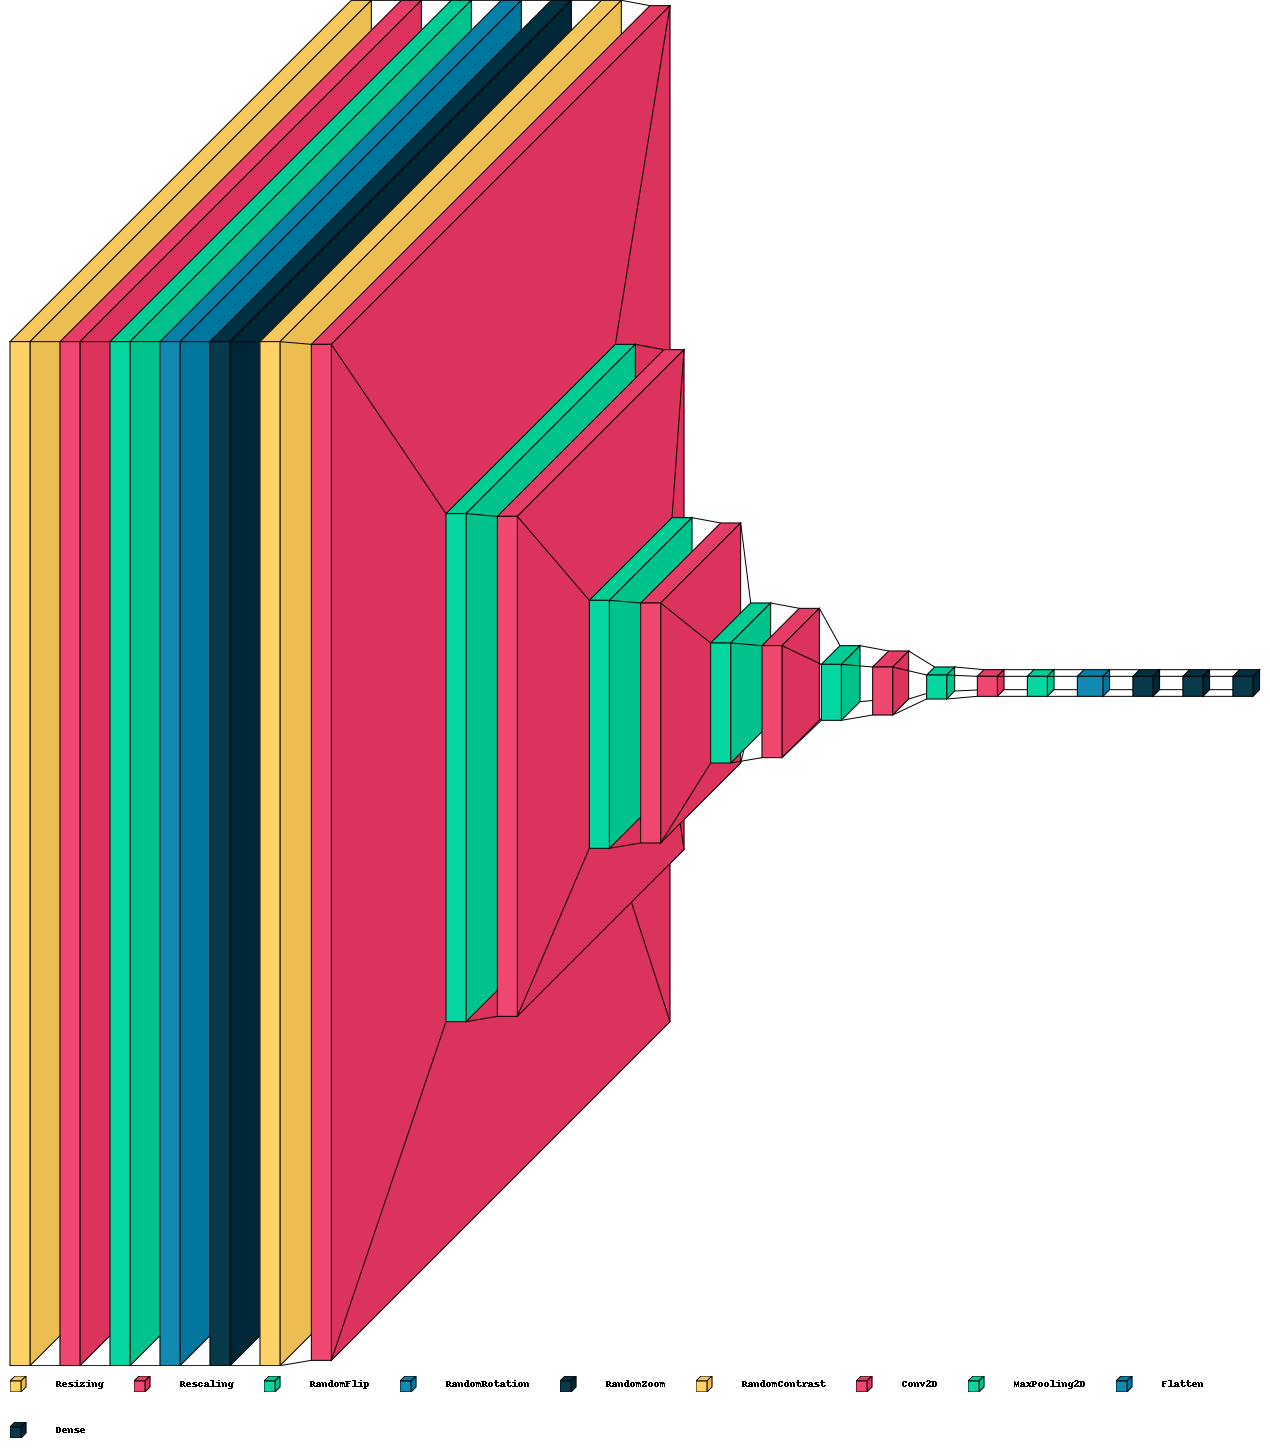

In [22]:
visualkeras.layered_view(model,legend = True, spacing=30,)

In [23]:
from tensorflow.keras.optimizers.legacy import Adam
model.compile(
    optimizer=Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 11s 94ms/step - loss: 0.9279 - accuracy: 0.4931 - val_loss: 0.9373 - val_accuracy: 0.4531
Epoch 2/10
54/54 [==============================] - 4s 83ms/step - loss: 0.7980 - accuracy: 0.5770 - val_loss: 0.5282 - val_accuracy: 0.7708
Epoch 3/10
54/54 [==============================] - 4s 83ms/step - loss: 0.5443 - accuracy: 0.7506 - val_loss: 0.3714 - val_accuracy: 0.8438
Epoch 4/10
54/54 [==============================] - 4s 83ms/step - loss: 0.3598 - accuracy: 0.8472 - val_loss: 0.3452 - val_accuracy: 0.8594
Epoch 5/10
54/54 [==============================] - 4s 83ms/step - loss: 0.3181 - accuracy: 0.8715 - val_loss: 0.3616 - val_accuracy: 0.8646
Epoch 6/10
54/54 [==============================] - 4s 83ms/step - loss: 0.2903 - accuracy: 0.8843 - val_loss: 0.3077 - val_accuracy: 0.8750
Epoch 7/10
54/54 [==============================] - 5s 83ms/step - loss: 0.2632 - accuracy: 0.8964 - val_loss: 0.5627 - val_accuracy: 0.8177
Epoch 8/10
5

In [25]:
model.save("./models/gpu_training_2.h5")

/home/drishtant/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
history.history['accuracy']

[0.4930555522441864,
 0.5769675970077515,
 0.7505787014961243,
 0.8472222089767456,
 0.8715277910232544,
 0.8842592835426331,
 0.8964120149612427,
 0.90625,
 0.9184027910232544,
 0.9293981194496155]

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
los = history.history['loss']
val_los = history.history['val_loss']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


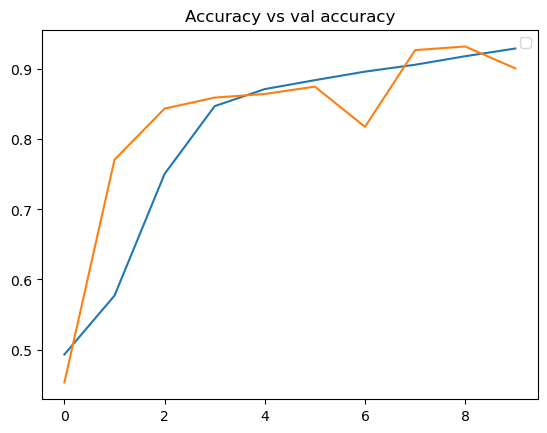

In [28]:
plt.plot(acc)
plt.plot(val_acc)
plt.title("Accuracy vs val accuracy")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


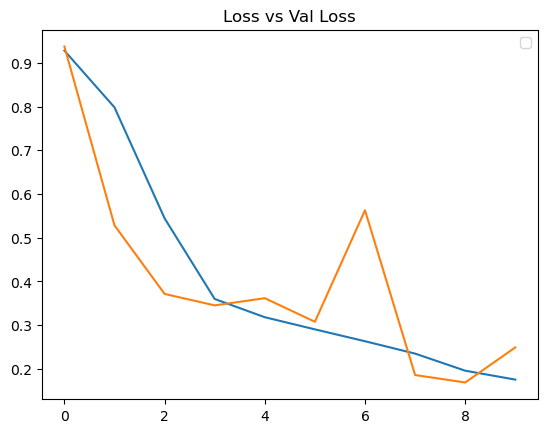

In [29]:
plt.plot(los)
plt.plot(val_los)
plt.title("Loss vs Val Loss")
plt.legend()

In [30]:
model.evaluate(test_ds)

8/8 [==============================] - 1s 70ms/step - loss: 0.2785 - accuracy: 0.8879


[0.2784944176673889, 0.8879310488700867]